<a href="https://colab.research.google.com/github/ArpanSM/MachineLearningHackathons/blob/master/Plant_Pathology_2020_FGVC7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning using 5 State of the Art Pre -Trained Networks

## Accuracy and Loss Achieved

Model ------------ Score(on Kaggle)

InceptionV3 ------ 0.876 

ResNet50 --------- 0.935

VGG16 ------------ 0.885

VGG19 ------------ 0.859

Xception --------- 0.878

## Approach

Approach

Read the train.csv and train images 

Clean and Pre - process

Resize images according to the input of Pre - trained model

X --> Load train images and convert them into numpy array for processing

y --> Load the labels and convert them into float type integer

Split the above data into train and validation

Data Augmentation 

Train and Validation Generator

Load Pretrained Network (finetune and addition according to need)

Train model with given training set

Test the model on test data

In [0]:
import pandas as pd
import cv2
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import keras
from keras import optimizers

Using TensorFlow backend.
/home/arpan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/arpan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/arpan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/arpan/anaconda3/lib/python3.7/site-packages/tensorflo

In [0]:
#input data
train=pd.read_csv("./train.csv")
test=pd.read_csv("./test.csv")

In [0]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [0]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


### Data Preprocessing

In [0]:
# making "image_id" names to match with input images by adding extension
train['image_id']=train['image_id']+'.jpg'
test['image_id']=test['image_id']+'.jpg'

In [0]:
print(train.head(5))
print("---------------------------------------------------------")
print(test.head(5))

      image_id  healthy  multiple_diseases  rust  scab
0  Train_0.jpg        0                  0     0     1
1  Train_1.jpg        0                  1     0     0
2  Train_2.jpg        1                  0     0     0
3  Train_3.jpg        0                  0     1     0
4  Train_4.jpg        1                  0     0     0
---------------------------------------------------------
     image_id
0  Test_0.jpg
1  Test_1.jpg
2  Test_2.jpg
3  Test_3.jpg
4  Test_4.jpg


In [0]:
#analyzing dataset
train.count()

image_id             1821
healthy              1821
multiple_diseases    1821
rust                 1821
scab                 1821
dtype: int64

In [0]:
#checking for null values
train.isnull().sum()

image_id             0
healthy              0
multiple_diseases    0
rust                 0
scab                 0
dtype: int64

In [0]:
#no null values!

In [0]:
#input shape according to pre trainied network
# ResNet50 --> 384
# VGG16 -- > 224
# VGG19 --> 224
# Xception --> 224
# InceptionV3 --> 224

img_size = 384

In [0]:
#resizing and shaping images for transfer learning with ResNet50
img=[]
filename=train.image_id
for file in filename:
    image=cv2.imread("./images/"+file)
    res=cv2.resize(image,(img_size,img_size))
    img.append(res)
img=np.array(img)

In [0]:
img.shape

(1821, 384, 384, 3)

In [0]:
#converting labels into float
train_labels = np.float32(train.loc[:, 'healthy':'scab'].values)
train_labels

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [0]:
#splitting data for training and validation
train, val = train_test_split(train, test_size = 0.15)

In [0]:
#data augmentation
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( horizontal_flip=True,
                                    vertical_flip=True,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=.1,
                                    fill_mode='nearest',
                                    shear_range=0.1,
                                    rescale=1/255)

In [0]:
train_generator=train_datagen.flow_from_dataframe(train,directory='./images/',
                                                      target_size=(img_size,img_size),
                                                      x_col="image_id",
                                                      y_col=['healthy','multiple_diseases','rust','scab'],
                                                      class_mode='raw',
                                                      shuffle=False,
                                                       subset='training',
                                                      batch_size=5)


val_generator=train_datagen.flow_from_dataframe(val,directory='./images/',
                                                      target_size=(img_size,img_size),
                                                      x_col="image_id",
                                                      y_col=['healthy','multiple_diseases','rust','scab'],
                                                      class_mode='raw',
                                                      shuffle=False,
                                                      batch_size=5)

test_generator=train_datagen.flow_from_dataframe(test,directory='./images/',
                                                      target_size=(img_size,img_size),
                                                      x_col="image_id",
                                                      y_col=None,
                                                      class_mode=None,
                                                      shuffle=False,
                                                      batch_size=5)

Found 1547 validated image filenames.
Found 274 validated image filenames.
Found 1821 validated image filenames.


# InceptionV3

In [0]:
from keras.applications import InceptionV3
model_finetuned = InceptionV3(include_top=False, weights='imagenet', input_shape=(img_size,img_size,3))

In [0]:
x = model_finetuned.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)

In [0]:
adam = keras.optimizers.Adam(learning_rate=0.000005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_finetuned = Model(inputs=model_finetuned.input, outputs=predictions)
model_finetuned.compile(optimizer=adam,
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
model_finetuned.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)
checkpoint = ModelCheckpoint("./model.{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5",
                             monitor="val_loss",
                             mode="auto",
                             save_best_only = True,
                             verbose=1)
callbacks = [PlotLossesKeras(),reduce_lr,checkpoint]

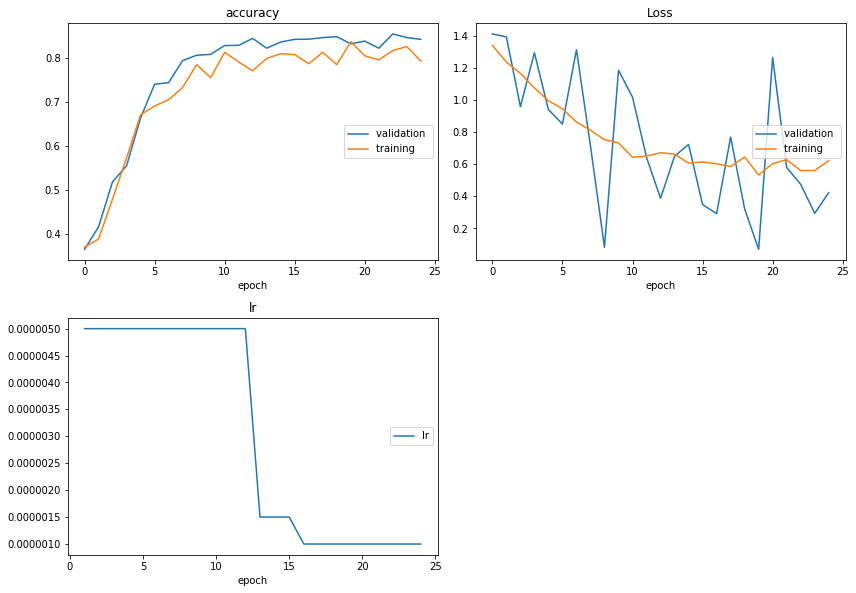

accuracy
	validation       	 (min:    0.365, max:    0.854, cur:    0.841)
	training         	 (min:    0.370, max:    0.836, cur:    0.792)
Loss
	validation       	 (min:    0.070, max:    1.411, cur:    0.423)
	training         	 (min:    0.533, max:    1.340, cur:    0.622)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)

Epoch 00025: val_loss did not improve from 0.07040


In [0]:
history = model_finetuned.fit_generator(train_generator,steps_per_epoch=100,epochs=25,validation_data=val_generator,validation_steps=100,callbacks = callbacks,use_multiprocessing=False,shuffle=True)

In [0]:
SUB_PATH = "./sample_submission.csv"
sub = pd.read_csv(SUB_PATH)
probs_InceptionV3 = model_finetuned.predict(test_generator, verbose=1)
sub.loc[:, 'healthy':] = probs_InceptionV3
sub.to_csv('submission_InceptionV3.csv', index=False)
sub.head()

365/365 [==============================] - 77s 211ms/step


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.432067,0.183365,0.228653,0.155915
1,Test_1,0.033342,0.040654,0.889189,0.036815
2,Test_2,0.031444,0.031660,0.019720,0.917175
3,Test_3,0.664428,0.100164,0.096073,0.139335
4,Test_4,0.000323,0.002236,0.994368,0.003072


# ResNet50

In [0]:
from keras.applications.resnet50 import ResNet50

In [0]:
model_finetuned = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size,img_size,3))

Instructions for updating:
Colocations handled automatically by placer.


/home/arpan/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
x = model_finetuned.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(4, activation="softmax")(x)

In [0]:
adam = keras.optimizers.Adam(learning_rate=0.000005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_finetuned = Model(inputs=model_finetuned.input, outputs=predictions)
model_finetuned.compile(optimizer=adam,
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
model_finetuned.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 390, 390, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 192, 192, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 192, 192, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)
checkpoint = ModelCheckpoint("./model.{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5",
                             monitor="val_loss",
                             mode="auto",
                             save_best_only = True,
                             verbose=1)
callbacks = [PlotLossesKeras(),reduce_lr]

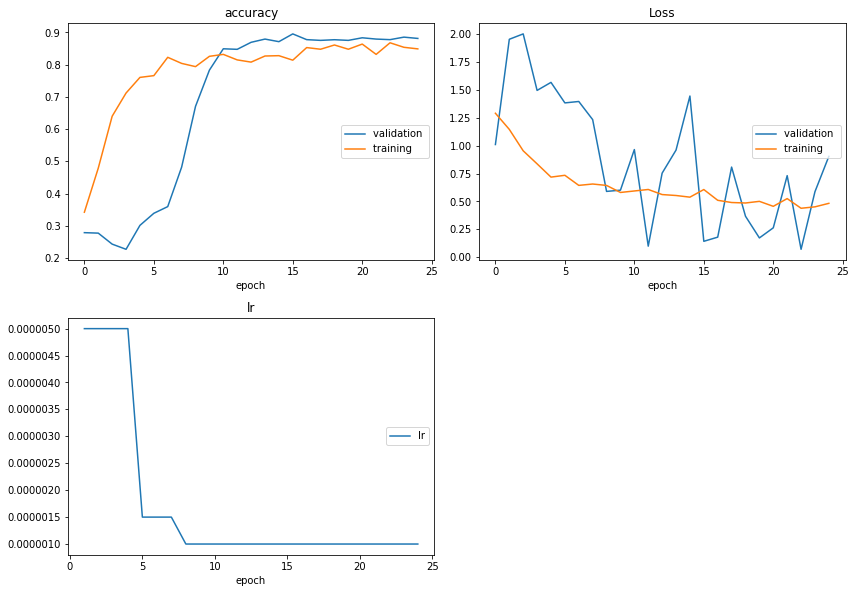

accuracy
	validation       	 (min:    0.227, max:    0.896, cur:    0.882)
	training         	 (min:    0.342, max:    0.868, cur:    0.849)
Loss
	validation       	 (min:    0.071, max:    2.004, cur:    0.905)
	training         	 (min:    0.439, max:    1.292, cur:    0.483)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)


In [0]:
history = model_finetuned.fit_generator(train_generator,steps_per_epoch=100,epochs=25,validation_data=val_generator,validation_steps=100,callbacks = callbacks,use_multiprocessing=False,shuffle=True)

In [0]:
SUB_PATH = "./sample_submission.csv"
sub = pd.read_csv(SUB_PATH)
probs_RESNET = model_finetuned.predict(test_generator, verbose=1)
sub.loc[:, 'healthy':] = probs_RESNET
sub.to_csv('submission_RESNET.csv', index=False)
sub.head()

365/365 [==============================] - 115s 315ms/step


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.081055,0.043995,0.813451,0.061499
1,Test_1,0.006444,0.046127,0.923563,0.023866
2,Test_2,0.020700,0.032261,0.005576,0.941462
3,Test_3,0.969971,0.003665,0.016411,0.009952
4,Test_4,0.000017,0.001266,0.998639,0.000078


# VGG16

In [0]:
#load model
model_finetuned = VGG16(include_top=False, weights='imagenet', input_shape=(img_size,img_size,3))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
x = model_finetuned.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)

In [0]:
adam = keras.optimizers.Adam(learning_rate=0.000005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_finetuned = Model(inputs=model_finetuned.input, outputs=predictions)
model_finetuned.compile(optimizer=adam,
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
model_finetuned.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)
checkpoint = ModelCheckpoint("./model.{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5",
                             monitor="val_loss",
                             mode="auto",
                             save_best_only = True,
                             verbose=1)
callbacks = [PlotLossesKeras(),reduce_lr,checkpoint]

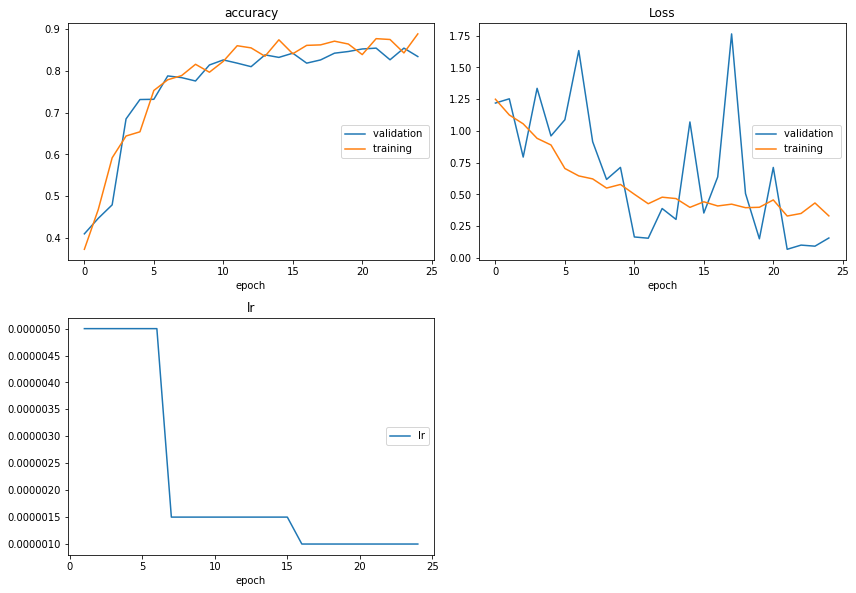

accuracy
	validation       	 (min:    0.411, max:    0.853, cur:    0.833)
	training         	 (min:    0.374, max:    0.887, cur:    0.887)
Loss
	validation       	 (min:    0.069, max:    1.764, cur:    0.158)
	training         	 (min:    0.331, max:    1.250, cur:    0.332)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)

Epoch 00025: val_loss did not improve from 0.06871


In [0]:
history_vgg16 = model_finetuned.fit_generator(train_generator,steps_per_epoch=100,epochs=25,validation_data=val_generator,validation_steps=100,callbacks = callbacks,use_multiprocessing=False,shuffle=True)

In [0]:
SUB_PATH = "./sample_submission.csv"
sub = pd.read_csv(SUB_PATH)
probs_VGG16 = model_finetuned.predict(test_generator, verbose=1)
sub.loc[:, 'healthy':] = probs_VGG16
sub.to_csv('submission_VGG16.csv', index=False)
sub.head()

365/365 [==============================] - 66s 181ms/step


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.009542,0.067860,0.784495,0.138104
1,Test_1,0.001551,0.055775,0.901524,0.041150
2,Test_2,0.001745,0.013011,0.001145,0.984099
3,Test_3,0.990908,0.001069,0.005947,0.002076
4,Test_4,0.000041,0.000691,0.999039,0.000229


# VGG19

In [0]:
from keras.applications.vgg19 import VGG19
model_finetuned = VGG19(include_top=False, weights='imagenet', input_shape=(img_size,img_size,3))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
x = model_finetuned.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)

In [0]:
adam = keras.optimizers.Adam(learning_rate=0.000005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_finetuned = Model(inputs=model_finetuned.input, outputs=predictions)
model_finetuned.compile(optimizer=adam,
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
model_finetuned.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)
checkpoint = ModelCheckpoint("./model.{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5",
                             monitor="val_loss",
                             mode="auto",
                             save_best_only = True,
                             verbose=1)
callbacks = [PlotLossesKeras(),reduce_lr,checkpoint]

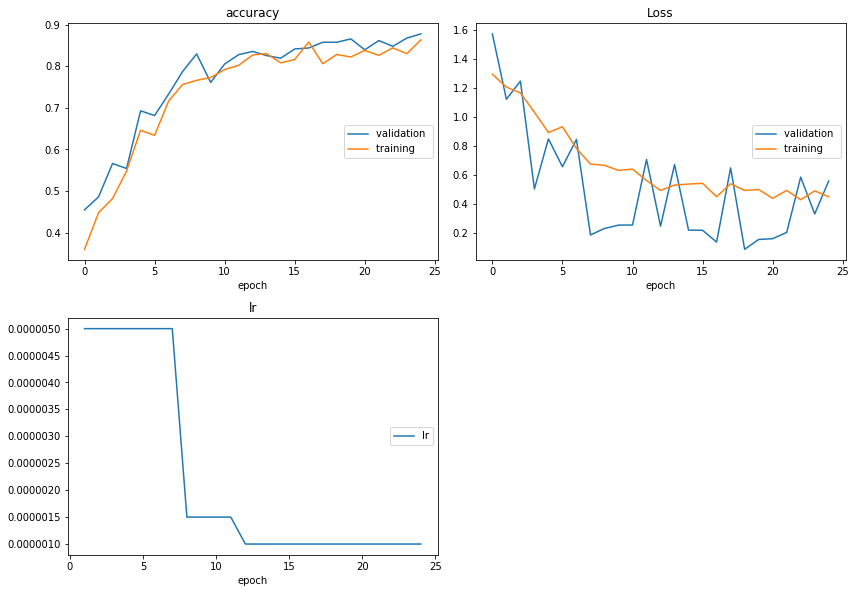

accuracy
	validation       	 (min:    0.455, max:    0.878, cur:    0.878)
	training         	 (min:    0.360, max:    0.863, cur:    0.863)
Loss
	validation       	 (min:    0.086, max:    1.575, cur:    0.558)
	training         	 (min:    0.429, max:    1.296, cur:    0.449)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)

Epoch 00025: val_loss did not improve from 0.08576


In [0]:
history_vgg19 = model_finetuned.fit_generator(train_generator,steps_per_epoch=100,epochs=25,validation_data=val_generator,validation_steps=100,callbacks = callbacks,use_multiprocessing=False,shuffle=True)

In [0]:
SUB_PATH = "./sample_submission.csv"
sub = pd.read_csv(SUB_PATH)
probs_VGG19 = model_finetuned.predict(test_generator, verbose=1)
sub.loc[:, 'healthy':] = probs_VGG19
sub.to_csv('submission_VGG19.csv', index=False)
sub.head()

365/365 [==============================] - 70s 193ms/step


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.046945,0.115182,0.744790,0.093083
1,Test_1,0.032540,0.158993,0.601060,0.207407
2,Test_2,0.019010,0.037376,0.008835,0.934779
3,Test_3,0.983426,0.004792,0.004148,0.007635
4,Test_4,0.003130,0.008352,0.987062,0.001455


In [0]:
from keras.applications import Xception
model_finetuned = Xception(include_top=False, weights='imagenet', input_shape=(img_size,img_size,3))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
x = model_finetuned.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)

In [0]:
adam = keras.optimizers.Adam(learning_rate=0.000005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_finetuned = Model(inputs=model_finetuned.input, outputs=predictions)
model_finetuned.compile(optimizer=adam,
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
model_finetuned.summary()
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)
checkpoint = ModelCheckpoint("./model.{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5",
                             monitor="val_loss",
                             mode="auto",
                             save_best_only = True,
                             verbose=1)
callbacks = [PlotLossesKeras(),reduce_lr,checkpoint]

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

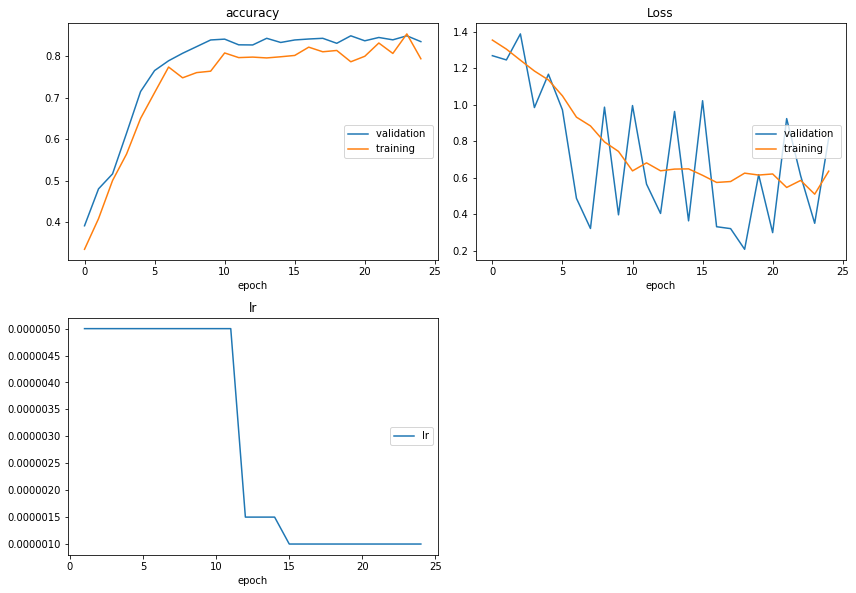

accuracy
	validation       	 (min:    0.391, max:    0.849, cur:    0.835)
	training         	 (min:    0.334, max:    0.854, cur:    0.794)
Loss
	validation       	 (min:    0.208, max:    1.387, cur:    0.818)
	training         	 (min:    0.510, max:    1.353, cur:    0.636)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)

Epoch 00025: val_loss did not improve from 0.20812


In [0]:
history_vgg19 = model_finetuned.fit_generator(train_generator,steps_per_epoch=100,epochs=25,validation_data=val_generator,validation_steps=100,callbacks = callbacks,use_multiprocessing=False,shuffle=True)

In [0]:
SUB_PATH = "./sample_submission.csv"
sub = pd.read_csv(SUB_PATH)
probs_Xception = model_finetuned.predict(test_generator, verbose=1)
sub.loc[:, 'healthy':] = probs_Xception
sub.to_csv('submission_Xception.csv', index=False)
sub.head()

365/365 [==============================] - 103s 282ms/step


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.046703,0.038921,0.870548,0.043829
1,Test_1,0.083707,0.047295,0.800505,0.068493
2,Test_2,0.064407,0.054447,0.040115,0.841031
3,Test_3,0.935912,0.009721,0.033996,0.020372
4,Test_4,0.012939,0.002830,0.977683,0.006547
